# Clasificador de radiografías
<br>

## Detección de Covid

In [1]:
import os
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
from skimage.io import imread
from skimage.transform import resize
import cv2
from sklearn import metrics

In [2]:
# comprobar conexion a la GPU
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU no encontrada')
print('Encontrada GPU: {}'.format(device_name))

Encontrada GPU: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Cargar el dataset
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 3

TRAIN_COVID_PATH = 'drive/MyDrive/DeteccionNeumonia/Covid/covid_dataset_ct_scans/CT_COVID/train/'
TRAIN_NonCOVID_PATH = 'drive/MyDrive/DeteccionNeumonia/Covid/covid_dataset_ct_scans/CT_NonCOVID/train/'

TEST_COVID_PATH = 'drive/MyDrive/DeteccionNeumonia/Covid/covid_dataset_ct_scans/CT_COVID/test/'
TEST_NonCOVID_PATH = 'drive/MyDrive/DeteccionNeumonia/Covid/covid_dataset_ct_scans/CT_NonCOVID/test/'


LOAD_FROM_IMAGES = False

def get_data(name, covid_path, NonCovid_path):
    COVID_ids = [f for f in os.listdir(covid_path) if os.path.isfile(os.path.join(covid_path, f))]
    for i in range(0,len(COVID_ids)):
        COVID_ids[i] = covid_path + COVID_ids[i]

    NonCOVID_ids = [f for f in os.listdir(NonCovid_path) if os.path.isfile(os.path.join(NonCovid_path, f))]
    for i in range(0,len(NonCOVID_ids)):
        NonCOVID_ids[i] = NonCovid_path + NonCOVID_ids[i]

    ids = COVID_ids + NonCOVID_ids

    x = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)

    print('Reescalando las imagenes de', name)
    for n, path in enumerate(ids):
        img = imread(path) # [:,:,:IMG_CHANNELS]
        img  = resize(img, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
        x[n] = img

    cont = 0
    cont2 = 0
    i = i + 1
    y = []
    while cont < len(COVID_ids):
        y.append([1])
        cont = cont + 1

    while cont2 < len(NonCOVID_ids):
        y.append([0])
        cont2 = cont2 + 1

    print('Convirtiendo a arrays de numpy')
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y


if LOAD_FROM_IMAGES:
    # cargar las imagenes a los arrays
    x_train, y_train = get_data('entrenamiento', TRAIN_COVID_PATH, TRAIN_NonCOVID_PATH)
    x_test, y_test = get_data('prueba', TEST_COVID_PATH, TEST_NonCOVID_PATH)
    
    # grabar los arrays en archivos
    np.save('drive/MyDrive/DeteccionNeumonia/Covid/xtrain_covid.npy', x_train)
    np.save('drive/MyDrive/DeteccionNeumonia/Covid/ytrain_covid.npy', y_train)
    np.save('drive/MyDrive/DeteccionNeumonia/Covid/xtest_covid.npy', x_test)
    np.save('drive/MyDrive/DeteccionNeumonia/Covid/ytest_covid.npy', y_test)
    print('Archivos guardados')
    
else:
    # cargar los arrays anteriormente grabados
    x_train = np.load('drive/MyDrive/DeteccionNeumonia/Covid/xtrain_covid.npy')
    y_train = np.load('drive/MyDrive/DeteccionNeumonia/Covid/ytrain_covid.npy')
    x_test = np.load('drive/MyDrive/DeteccionNeumonia/Covid/xtest_covid.npy')
    y_test = np.load('drive/MyDrive/DeteccionNeumonia/Covid/ytest_covid.npy')
    print('Archivos cargados')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivos cargados


In [4]:
classification = ['NonCOVID', 'COVID']

y_train_one_hot = tensorflow.keras.utils.to_categorical(y_train)
y_test_one_hot = tensorflow.keras.utils.to_categorical(y_test)

x_train = x_train / 255
x_test = x_test / 255

print(y_train_one_hot.shape)
print(y_test_one_hot.shape)
print(x_train.shape)
print(x_test.shape)

(465, 2)
(224, 2)
(465, 64, 64, 3)
(224, 64, 64, 3)


Covid


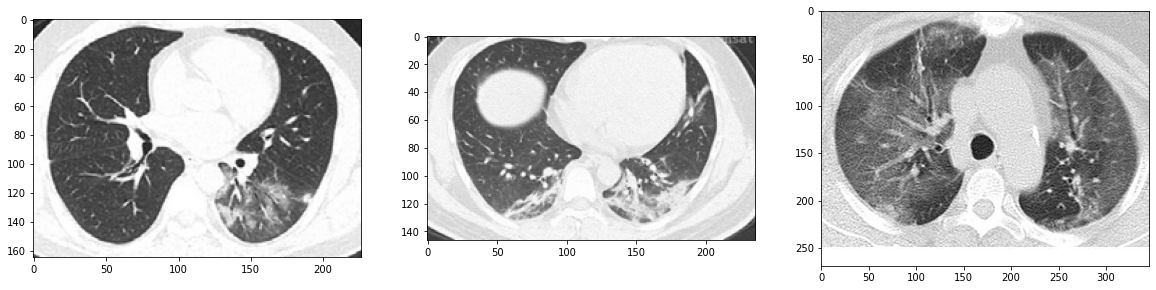

In [5]:
# mostrar varias imagenes (radiografias)
multipleImages = glob('drive/MyDrive/DeteccionNeumonia/Covid/covid_dataset_ct_scans/CT_COVID/train/**')

def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2]));
    
print('Covid')
plotThreeImages(multipleImages)

NonCovid


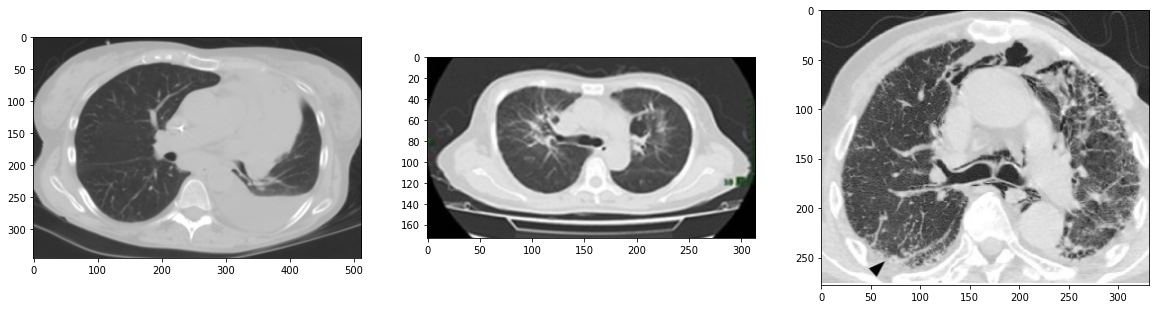

In [6]:
# mostrar varias imagenes (radiografias)
multipleImages = glob('drive/MyDrive/DeteccionNeumonia/Covid/covid_dataset_ct_scans/CT_NonCOVID/train/**')

def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2]));
    
print('NonCovid')
plotThreeImages(multipleImages)

In [7]:
# Create the architecture
model = tensorflow.keras.models.Sequential()

# First layer: convlutional layer (extract features from the input image)
model.add(tensorflow.keras.layers.Conv2D(64, (5, 5), activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS)))

# Second layer: pooling layer with a 2x2 pixel filter
model.add(tensorflow.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Third layer: convolution layer and pooling layer
model.add(tensorflow.keras.layers.Conv2D(128, (5, 5), activation='relu'))
model.add(tensorflow.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Forth layer: flattening layer (reduce image to linear array)
model.add(tensorflow.keras.layers.Flatten())

# Neural network: first layer has 1000 neurons and the activation function ReLu
model.add(tensorflow.keras.layers.Dense(1000, activation='relu'))

# Fifth layer: drop out of 50%
model.add(tensorflow.keras.layers.Dropout(0.5))

model.add(tensorflow.keras.layers.Dense(500, activation='relu'))

model.add(tensorflow.keras.layers.Dropout(0.5))

# Neural network: first layer has 250 neurons and the activation function ReLu
model.add(tensorflow.keras.layers.Dense(250, activation='relu'))

# Last layer of this neural network with 10 neurons (one for each label) using the softmax function
model.add(tensorflow.keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense (Dense)                (None, 1000)              21633000  
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0

In [8]:
# Compilar el modelo

model.compile(loss='categorical_crossentropy', optimizer='adam')

callbacks = [tensorflow.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'), tensorflow.keras.callbacks.TensorBoard(log_dir='drive/MyDrive/DeteccionNeumonia/Covid/logs_5')]

hist = model.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), batch_size=32, epochs=30, callbacks=callbacks)

Epoch 1/30
15/15 [==============================] - 4s 89ms/step - loss: 0.9186 - val_loss: 0.6875
Epoch 2/30
15/15 [==============================] - 0s 16ms/step - loss: 0.6608 - val_loss: 0.6622
Epoch 3/30
15/15 [==============================] - 0s 19ms/step - loss: 0.6499 - val_loss: 0.6672
Epoch 4/30
15/15 [==============================] - 0s 24ms/step - loss: 0.6644 - val_loss: 0.6660
Epoch 5/30
15/15 [==============================] - 0s 16ms/step - loss: 0.6447 - val_loss: 1.1968
Epoch 6/30
15/15 [==============================] - 0s 16ms/step - loss: 0.6010 - val_loss: 1.1589
Epoch 7/30
15/15 [==============================] - 0s 19ms/step - loss: 0.5775 - val_loss: 0.9347
Epoch 8/30
15/15 [==============================] - 0s 15ms/step - loss: 0.5575 - val_loss: 0.8557
Epoch 9/30
15/15 [==============================] - 0s 16ms/step - loss: 0.5228 - val_loss: 0.8346
Epoch 10/30
15/15 [==============================] - 0s 16ms/step - loss: 0.4640 - val_loss: 1.9031
Epoch 11/

In [9]:
# Medir precicion

pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)
y_compare = np.argmax(y_test_one_hot, axis=1)
score = metrics.accuracy_score(y_compare, pred)
AUC = metrics.roc_auc_score(y_compare, pred)
DS = metrics.f1_score(y_compare, pred)

print("Accuracy: {}".format(score))
print("AUC: {}".format(AUC))
print("Dice Score: {}".format(DS))

Accuracy: 0.7142857142857143
AUC: 0.7073793378540087
Dice Score: 0.6049382716049383


In [10]:
model.save('drive/MyDrive/DeteccionNeumonia/Covid/CNN_originla_bo_5.h5')
model.save_weights("drive/MyDrive/DeteccionNeumonia/Covid/CNN_original_weights_bo_5.h5")
print("Modelo guardado")

Modelo guardado


COVID : 90.81 %
NonCOVID : 9.19 %


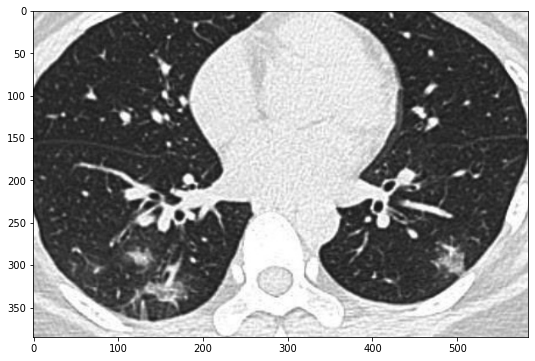

In [11]:
# Probar modelo

# new_image = cv2.imread('drive/MyDrive/DeteccionNeumonia/Covid/covid_dataset_ct_scans/val/CT_NonCOVID/1952.png')
new_image = cv2.imread('drive/MyDrive/DeteccionNeumonia/Covid/covid_dataset_ct_scans/val/CT_COVID/kjr-21-e25-p1-14.png')
resized_image = resize(new_image, (IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
prediction = model.predict(np.array( [resized_image] ))

list_index = [0,1]
x = prediction
for i in range(2):
    for j in range(2):
        if x[0][list_index[i]] > x[0][list_index[j]]:
            temp = list_index[i]
            list_index[i] = list_index[j]
            list_index[j] = temp

i=0
for i in range(2):
    print(classification[list_index[i]], ':', round(prediction[0][list_index[i]] * 100, 2), '%')

plt.figure(figsize=(12,6))
plt.imshow(new_image, cmap='gray', vmin=0, vmax=1)
plt.show()

## Etrenamiento con los pesos guardados

In [12]:
# Create the architecture
model2 = tensorflow.keras.models.Sequential()

# First layer: convlutional layer (extract features from the input image)
model2.add(tensorflow.keras.layers.Conv2D(64, (5, 5), activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS)))

# Second layer: pooling layer with a 2x2 pixel filter
model2.add(tensorflow.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Third layer: convolution layer and pooling layer
model2.add(tensorflow.keras.layers.Conv2D(128, (5, 5), activation='relu'))
model2.add(tensorflow.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Forth layer: flattening layer (reduce image to linear array)
model2.add(tensorflow.keras.layers.Flatten())

# Neural network: first layer has 1000 neurons and the activation function ReLu
model2.add(tensorflow.keras.layers.Dense(1000, activation='relu'))

# Fifth layer: drop out of 50%
model2.add(tensorflow.keras.layers.Dropout(0.5))

model2.add(tensorflow.keras.layers.Dense(500, activation='relu'))

model2.add(tensorflow.keras.layers.Dropout(0.5))

# Neural network: first layer has 250 neurons and the activation function ReLu
model2.add(tensorflow.keras.layers.Dense(250, activation='relu'))

# Last layer of this neural network with 10 neurons (one for each label) using the softmax function
model2.add(tensorflow.keras.layers.Dense(2, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 60, 60, 64)        4864      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       204928    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              21633000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)             

In [13]:
# Compilar el modelo

model2.compile(loss='categorical_crossentropy', optimizer='adam')

In [14]:
# cargar los pesos desde el archivo guardado
from tensorflow.keras.models import load_model

# checkpoint_path = "drive/MyDrive/DeteccionNeumonia/Covid/CNN_original_weights_bo.h5"
# model2.load_weights(checkpoint_path)


# Hacer predicciones con el modelo completo guardado
model2 = load_model('drive/MyDrive/DeteccionNeumonia/Covid/CNN_originla_bo_4.h5')


# Medir precision
pred = model2.predict(x_test)
pred = np.argmax(pred, axis=1)
y_compare = np.argmax(y_test_one_hot, axis=1)
score = metrics.accuracy_score(y_compare, pred)
AUC = metrics.roc_auc_score(y_compare, pred)
DS = metrics.f1_score(y_compare, pred)

print("Accuracy: {}".format(score))
print("AUC: {}".format(AUC))
print("Dice Score: {}".format(DS))

Accuracy: 0.6919642857142857
AUC: 0.6851615476665337
Dice Score: 0.5766871165644172


COVID : 99.79 %
NonCOVID : 0.21 %


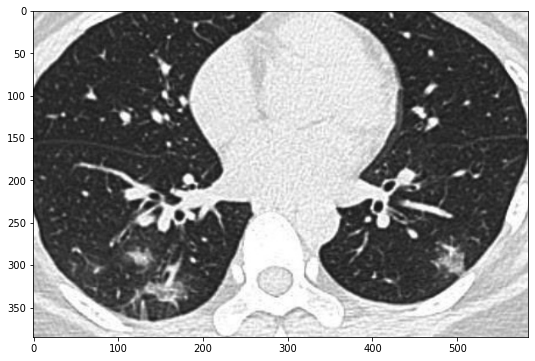

In [15]:
# Probar modelo

# new_image = cv2.imread('drive/MyDrive/DeteccionNeumonia/Covid/covid_dataset_ct_scans/val/CT_NonCOVID/1952.png')
new_image = cv2.imread('drive/MyDrive/DeteccionNeumonia/Covid/covid_dataset_ct_scans/val/CT_COVID/kjr-21-e25-p1-14.png')
resized_image = resize(new_image, (IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
prediction = model2.predict(np.array( [resized_image] ))

list_index = [0,1]
x = prediction
for i in range(2):
    for j in range(2):
        if x[0][list_index[i]] > x[0][list_index[j]]:
            temp = list_index[i]
            list_index[i] = list_index[j]
            list_index[j] = temp

i=0
for i in range(2):
    print(classification[list_index[i]], ':', round(prediction[0][list_index[i]] * 100, 2), '%')

plt.figure(figsize=(12,6))
plt.imshow(new_image, cmap='gray', vmin=0, vmax=1)
plt.show()